In [1]:
# estimation of "survived" using a Random Forest Classifier

In [26]:
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_train = pd.read_csv('./Dataset/train.csv')
data_test = pd.read_csv('./Dataset/test.csv')

In [4]:
# function to transform the first part of the name
def transform_first(x, first_n):
    fst = x.split(',')[0]
    return first_n[fst]

# function to transform the title 
def transform_title(x):
    group_0 = ['Mr', 'Mrs', 'Miss', 'Mme', 'Ms', 'Mlle']
    group_1 = ['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt']
    title = x.split(',')[1]
    status = 2
    for t in group_0:
        if t in title:
            status = 0
    for t in group_1:
        if t in title:
            status = 1
    return status

def transform(df):
    attr_to_val = {}
    attr_to_val["Pclass"] = {"1fst":1, "2nd":2, "3rd":3}
    attr_to_val["hasCabin"] = {"no":0, "yes":1}
    df["hasCabin"] = np.where(pd.isnull(df['Cabin']), 0, 1)
    attr_to_val["Sex"] = {"male":0, "female":1}
    df["Sex"] = np.where(df["Sex"]=="male", 0, 1)
    attr_to_val["Embarked"] = {'C':0, 'Q':1, 'S':2, np.nan:3} 
    df["Embarked"] = df["Embarked"].map(attr_to_val["Embarked"], na_action=None)
    
    names = df['Name'].to_list()
    n1 = [n.split(',')[0] for n in names]
    first_n = Counter(n1)
    
    df["n1"] = df["Name"].apply(lambda x: transform_first(x, first_n))
    
    attr_to_val["n2"] = {'group 0': 0 , "group 1": 1, "ukn":2}
    df["n2"] = df["Name"].apply(lambda x: transform_title(x))
    
    mAge = df['Age'].mean()
    df['Age'] = df['Age'].fillna(mAge)
    return df, attr_to_val# reduction of the dataset

def reduction(df):
    return df[['Survived', 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'hasCabin', 'n1', 'n2']]

def normalization(df):
    hist_norm = {}
    for at in df.columns:
        m = df[at].min()
        M = df[at].max()
        hist_norm[at] = (m, M)
    dfn = (df - df.min()) / (df.max() - df.min())
    return dfn, hist_norm

In [5]:
df, attr = transform(data_train)
df = reduction(df)
df, hist_norm = normalization(df)

In [6]:
df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasCabin,n1,n2
0,0.0,1.0,0.0,0.271174,0.125,0.0,0.014151,0.666667,0.0,0.125,0.0
1,1.0,0.0,1.0,0.472229,0.125,0.0,0.139136,0.000000,1.0,0.000,0.0
2,1.0,1.0,1.0,0.321438,0.000,0.0,0.015469,0.666667,0.0,0.000,0.0
3,1.0,0.0,1.0,0.434531,0.125,0.0,0.103644,0.666667,1.0,0.125,0.0
4,0.0,1.0,0.0,0.434531,0.000,0.0,0.015713,0.666667,0.0,0.125,0.0


In [9]:
# split the dataset 
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
data = []
for df in [df_train, df_test]:
    y = df['Survived'].values
    x = df.drop('Survived', axis=1).values
    data += [(x, y)]

In [23]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(data[0][0], data[0][1])

RandomForestClassifier(max_depth=4, random_state=0)

In [24]:
score_train = clf.score(data[0][0], data[0][1])
score_test = clf.score(data[1][0], data[1][1])
print(score_train, score_test)

0.8651685393258427 0.8097014925373134


In [42]:
# we define a function to train a model using
# 5-fold cross validation
# the main purpose of this function is to find the best hyper-parameters
# the function return the stats of the scores (min, mean, max)
def search_model(depth=4, estimators=100):
    Y = df['Survived'].values
    X = df.drop('Survived', axis=1).values
    scores = []
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        Xtr, Xte = X[train_index], X[test_index]
        Ytr, Yte = Y[train_index], Y[test_index]
        clf = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=0)
        clf.fit(Xtr, Ytr)
        scores += [clf.score(Xte, Yte)]
    mi, me, ma = np.min(scores), np.mean(scores), np.max(scores)
    print("estimators: {}, depth: {}".format(estimators, depth))
    print("score mean: {}".format(me))
    print("score min max: {} {}".format(mi, ma))
    print('')
    return (mi, me, ma)

In [43]:
results = []
for i in range(1, 10):
    r = search_model(depth=i)
    results += [r]

estimators: 100, depth: 1
score mean: 0.7312368972746331
score min max: 0.660377358490566 0.8148148148148148

estimators: 100, depth: 2
score mean: 0.7612159329140461
score min max: 0.7037037037037037 0.8333333333333334

estimators: 100, depth: 3
score mean: 0.7838574423480084
score min max: 0.6851851851851852 0.8301886792452831

estimators: 100, depth: 4
score mean: 0.8059399021663174
score min max: 0.7592592592592593 0.8333333333333334

estimators: 100, depth: 5
score mean: 0.8247379454926624
score min max: 0.7407407407407407 0.8679245283018868

estimators: 100, depth: 6
score mean: 0.8322152341020266
score min max: 0.7592592592592593 0.8518518518518519

estimators: 100, depth: 7
score mean: 0.835988819007687
score min max: 0.7592592592592593 0.8703703703703703

estimators: 100, depth: 8
score mean: 0.8322851153039833
score min max: 0.7592592592592593 0.9056603773584906

estimators: 100, depth: 9
score mean: 0.8210342417889587
score min max: 0.7592592592592593 0.8679245283018868



In [44]:
mis, mes, mas = zip(*results)

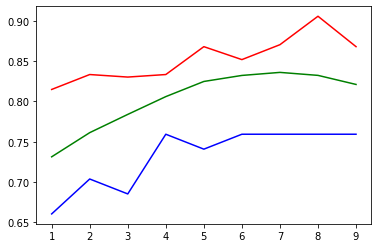

In [45]:
# we plot the results 
for m, c, lab in zip([mis, mes, mas], ['blue', 'green', 'red'], ["min", "mean", "max"]):
    plt.plot(np.arange(1, 10), m, c, label=lab)
plt.legend()
plt.xlabel("depth")
plt.ylabel("score")

In [ ]:
# following these results, the best value for depth is 7

estimators: 10, depth: 7
score mean: 0.806009783368274
score min max: 0.7592592592592593 0.8333333333333334

estimators: 20, depth: 7
score mean: 0.8133473095737248
score min max: 0.7777777777777778 0.8518518518518519

estimators: 30, depth: 7
score mean: 0.8170510132774282
score min max: 0.7777777777777778 0.8703703703703703

estimators: 40, depth: 7
score mean: 0.8210342417889587
score min max: 0.7407407407407407 0.8679245283018868

estimators: 50, depth: 7
score mean: 0.8246680642907058
score min max: 0.7592592592592593 0.8518518518518519

estimators: 60, depth: 7
score mean: 0.8285115303983229
score min max: 0.7592592592592593 0.8679245283018868

estimators: 70, depth: 7
score mean: 0.8285115303983229
score min max: 0.7592592592592593 0.8679245283018868

estimators: 80, depth: 7
score mean: 0.835988819007687
score min max: 0.7592592592592593 0.8703703703703703

estimators: 90, depth: 7
score mean: 0.8284416491963661
score min max: 0.7592592592592593 0.8703703703703703

estimators: 

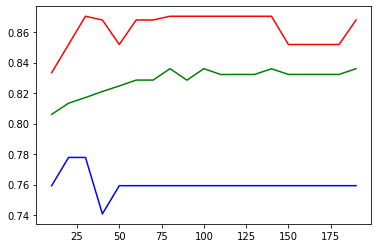

In [50]:
results = []
xsteps = np.arange(10, 200, 10)
for i in xsteps:
    r = search_model(depth=7, estimators=i)
    results += [r]
mis, mes, mas = zip(*results)
for m, c, lab in zip([mis, mes, mas], ['blue', 'green', 'red'], ["min", "mean", "max"]):
    plt.plot(xsteps, m, c, label=lab)
plt.legend()
plt.xlabel("estimators")
plt.ylabel("score")

estimators: 25, depth: 1
score mean: 0.7122990915443744
score min max: 0.6037735849056604 0.8148148148148148

estimators: 25, depth: 2
score mean: 0.738993710691824
score min max: 0.6481481481481481 0.8148148148148148

estimators: 25, depth: 3
score mean: 0.783717679944095
score min max: 0.7037037037037037 0.8301886792452831

estimators: 25, depth: 4
score mean: 0.8059399021663172
score min max: 0.7592592592592593 0.8703703703703703

estimators: 25, depth: 5
score mean: 0.7725366876310272
score min max: 0.7037037037037037 0.8148148148148148

estimators: 25, depth: 6
score mean: 0.809853249475891
score min max: 0.7777777777777778 0.8301886792452831

estimators: 25, depth: 7
score mean: 0.8134171907756814
score min max: 0.7777777777777778 0.8703703703703703

estimators: 25, depth: 8
score mean: 0.817330538085255
score min max: 0.7777777777777778 0.8679245283018868

estimators: 25, depth: 9
score mean: 0.8171907756813418
score min max: 0.7592592592592593 0.8518518518518519



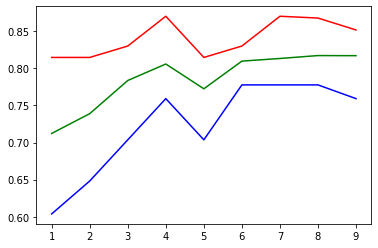

In [51]:
results = []
xsteps = np.arange(1, 10, 1)
for i in xsteps:
    r = search_model(depth=i, estimators=25)
    results += [r]
mis, mes, mas = zip(*results)
for m, c in zip([mis, mes, mas], ['blue', 'green', 'red']):
    plt.plot(xsteps, m, c)

In [ ]:
# One possible paramters are depth 6, estimator 25